# Guide to Extracting Data w/ APIs from the Dexcom G6 PRO

<img src="https://www.medgadget.com/wp-content/uploads/2020/06/IMG_0914-1024x577.jpeg" width="500"/>


Ever wanted to constantly monitor your blood glucose every 5 minutes, 24/7? With the [Dexcom G6 PRO CGM device](https://provider.dexcom.com/products/dexcom-g6-pro), you can track your glucose levels continuously over time and beam this data back so you can analyze it for yourself. In this notebook, we'll be showing you how to do just that, assuming you already have a Dexcom G6 PRO CGM device set up and tracking.

If you want to know more about the Dexcom G6 PRO CGM device, see the [README](https://github.com/alrojo/wearipedia/tree/main/wearables/dexcom-g6-pro) for a detailed analysis of performances, sensors, data privacy, and extraction pipelines.

We were able to extract glucose levels at a sampling rate of every 5 minutes from the API.

<br><br>
In this guide, we sequentially cover the following **five** topics to extract from the Dexcom API:
1. **Setup**
2. **Authentication/Authorization**
    - This requires a couple extra steps on your part
3. **Data extraction**
    - You can get data from the API between any given date range in a couple lines of code.
4. **Data visualization**
    - 4.1: We reproduce a plot from the Dexcom Clarity website that shows aggregated glucose levels over the course of a given day.
    - 4.2: We visualize when data was collected throughout the year.
        - We achieve this by plotting a calendar heatmap depicting when the user has been wearing the device by coloring according to the number of hours in the day at least 3 glucose measurements were logged.
    - 4.3: We reproduce the plot of glucose levels over a *particular day of interest*.
5. **Data analysis**
    - 5.1: We analyze whether glucose levels change significantly between nighttime and daytime.
    - 5.2: We analyze whether glucose level *variability* changes significantly between nighttime and daytime.
    - 5.3: We check for anomalies in the data.

Disclaimer: this notebook is purely for educational purposes. All of the data currently stored in this notebook is purely *synthetic*, meaning randomly generated according to rules we created. Despite this, the end-to-end data extraction pipeline has been tested on our own data, meaning that if you enter your own credentials on your own Colab instance, you can visualize your own *real* data. That being said, we were unable to thoroughly test the timezone functionality, though, since we only have one account, so beware.

# 1. Setup

## 1.1 Study participant setup and usage

To set up the CGM device itself so that you can run this notebook, you can follow the [official instructions on the website](https://provider.dexcom.com/education-research/cgm-education-use/videos/getting-started-dexcom-g6-and-setting-g6-app).

# 2. Authentication/Authorization

To be able to make requests to the API, the easiest way is to use the public developer API. We'll be roughly following the official steps outlined [here](https://developer.dexcom.com/authentication).

First, set up your developer app:

1. Register for a new developer account at [this link](https://developer.dexcom.com/user/register). Note that you can use any email you like, and it does not need to match the user email.
2. Once logged in, click the green button titled "Add an app".
3. Give the app any name you want, any description, and for Redirect URI you can entire in `https://www.google.com` (can be any valid base URL, but this is probably simplest).

In the end, you should see something like the below.

<img src="https://i.imgur.com/j8WBnHH.png"></img>

Now we can proceed with the rest of the notebook. Enter your the credentials from the app, and make sure that the redirect URI matches.

In [ ]:
#@title Enter your credentials

# for calendar plot
!pip install -q july

import requests
import urllib
import json
from datetime import datetime
import http.client

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import july
from july.utils import date_range


your_client_secret = "NtWS1ViwrO9zuNkZ" #@param {type:"string"}
your_client_id = "n92KUDE2pumPUO4u3FStNhKmmpUaV7Gw" #@param {type:"string"}
your_redirect_uri = "https://www.google.com" #@param {type:"string"}
your_state_value = '1234'

url = f'https://api.dexcom.com/v2/oauth2/login?client_id={your_client_id}&redirect_uri={your_redirect_uri}&response_type=code&scope=offline_access&state={your_state_value}'

print(url)

https://api.dexcom.com/v2/oauth2/login?client_id=n92KUDE2pumPUO4u3FStNhKmmpUaV7Gw&redirect_uri=https://www.google.com&response_type=code&scope=offline_access&state=1234


Visit the above URL and authorize yourself. You should see a page like this. In our case, enter `anusridh@stanford.edu` and `Stanford123` as the password.

<img src="https://imgur.com/9QyqTAd.png"></img>

You may have to go through a second page where you have to type in your signature. Then, once you go through this portal, copy the URL you were redirected to below. You must do this quickly (there is a one minute expiration countdown).

This will grant us an access token that lasts 10 minutes.

In [ ]:
#@title Copy the URL into the text box below
redirect_url = "https://www.google.com/?code=6fa48a835c032d81eba4991963106771&state=1234" #@param {type:"string"}

try:
    your_authorization_code = urllib.parse.parse_qs(urllib.parse.urlparse(redirect_url).query)['code'][0]
except Exception as e:
    print(f'Caught error:\n{e}\n')
    print("Please copy and paste the entire URL (including https)")


conn = http.client.HTTPSConnection("api.dexcom.com")

payload = f"client_secret={your_client_secret}&client_id={your_client_id}&code={your_authorization_code}&grant_type=authorization_code&redirect_uri={your_redirect_uri}"

headers = {
    'content-type': "application/x-www-form-urlencoded",
    'cache-control': "no-cache"
    }

conn.request("POST", "/v2/oauth2/token", payload, headers)

res = conn.getresponse()
data = res.read()

json_response = json.loads(data.decode('utf-8'))

if 'error' in json_response.keys() and json_response['error'] == 'invalid_grant':
    print('The code you got has expired.')
    print('Authorize and enter the redirect URL again.')
else:
    access_token = json.loads(data.decode('utf-8'))['access_token']

    print(f'Entire response was {data.decode("utf-8")}')
    print(f'Our access token is {access_token}')

The code you got has expired.
Authorize and enter the redirect URL again.


# 3. Data extraction

Data extraction is fairly simple for this API. For documentation about what endpoints you can hit and what data you can get, see [this official link](https://developer.dexcom.com/endpoint-overview). Here, we'll just extract the time-varying CGM values, which you can see more details for [here](https://developer.dexcom.com/get-egvs).

Note: the start and end dates must be within 90 days of each other.

In [ ]:
#@title Enter start and end dates

from datetime import timedelta
from tqdm import tqdm
from scipy.ndimage import gaussian_filter

start_day = datetime.strptime('2022-03-31', '%Y-%m-%d')

def lerp(x1, x2, t):
    return t * x2 + (1 - t) * x1

base_keypoints = [100] * 4 + [120] * 4 + [130] * 8 + [120] * 4 + [100] * 4

def create_synth_df():
    datetimes = []
    glucoses = []

    for day_offset in tqdm(range(12)):
        if day_offset != 0:
            overlap = keypoints[-1]
        keypoints = list(np.random.randn(24) * 10 + np.array(base_keypoints))
        if day_offset != 0:
            keypoints[0] = overlap

        keypoints = keypoints + [keypoints[0]]

        for minute_offset in range(0, 24 * 60, 5):
            minute = start_day + timedelta(days=day_offset) + timedelta(minutes=minute_offset)

            scaled_offset = minute_offset / 60

            k1 = keypoints[np.floor(scaled_offset).astype('int')]
            k2 = keypoints[np.ceil(scaled_offset).astype('int')]

            value = lerp(k1, k2, scaled_offset % 1)
            if value > 130:
                scaling = 30
            else:
                scaling = 15
            value += np.random.randn() * scaling

            datetimes.append(minute)
            glucoses.append(value)

    synth_df = pd.DataFrame()

    synth_df['datetime'] = datetimes
    synth_df['glucose_level'] = gaussian_filter(glucoses, 2, mode='constant')

    synth_df['Time of Day'] = ['Day' if dt.hour in range(8, 20) else 'Night' for dt in datetimes]
    synth_df['Rates of change'] = np.random.randn(synth_df.shape[0])
    synth_df['Rates of change'].iloc[np.where(synth_df['Time of Day'] == 'Day')[0]] *= 3

    # take out some rows to create missing values

    missing_start = datetime.strptime('2022-04-06', '%Y-%m-%d') + timedelta(hours=14)
    missing_end = missing_start + timedelta(minutes=70)

    synth_df = synth_df.drop(np.where(np.logical_and(synth_df.datetime > missing_start, synth_df.datetime < missing_end))[0])

    return synth_df

start_date = "2022-02-16" #@param {type:"date"}
end_date = "2022-05-16" #@param {type:"date"}
synthetic = True #@param {type:"boolean"}

if synthetic:
    df = create_synth_df()
else:
    start_date = start_date + 'T15:30:00'
    end_date = end_date + 'T15:45:00'

    headers = {
        'authorization': f"Bearer {access_token}"
    }

    endpoint = f'https://api.dexcom.com/v2/users/self/egvs?startDate={start_date}&endDate={end_date}'

    out = json.loads(requests.get(endpoint, headers=headers).text)

    if 'errors' in out.keys():
        print(f'Got error(s) {out["errors"]}. Fix start and end dates and rerun.')
    elif 'fault' in out.keys():
        print(f'Got fault {out["fault"]}. You might need to request another access token.')
    else:
        def dt_string_to_obj(dt_str):
            # converts string like "2022-04-10T10:13:00" to a datetime object
            return datetime.strptime(dt_str, '%Y-%m-%dT%H:%M:%S')
            

        data_dict = [{'datetime': dt_string_to_obj(x['displayTime']), 'glucose_level': x['realtimeValue']} for x in out['egvs'][::-1]]

        df = pd.DataFrame.from_dict(data_dict)

100%|██████████| 12/12 [00:00<00:00, 124.69it/s]
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


The code hidden above initialized `df`, a Pandas dataframe that represents the time series values for glucose. If we look at the `glucose_level` column without time information, we'll see the following...

In [ ]:
df.glucose_level.describe()

count    3443.000000
mean      115.135375
std        15.332945
min        53.110343
25%       103.611643
50%       117.088519
75%       125.586401
max       168.108454
Name: glucose_level, dtype: float64

As we can see, this user's glucose levels are around 100 mg/dL on average.

And if we see how quickly the values were sampled at, we can see that they tend to be sampled in increments of 300 seconds, or 5 minutes.

In [ ]:
diffs = np.diff(df.datetime.apply(lambda x: x.timestamp()))
pd.DataFrame(diffs).describe()

,0
count,3442.000000
mean,301.133062
std,66.475127
min,300.000000
25%,300.000000
50%,300.000000
75%,300.000000
max,4200.000000


# 4. Data Visualization

As a first attempt, let's see what they look like when we plot the levels over time (where time is the display time on the device).

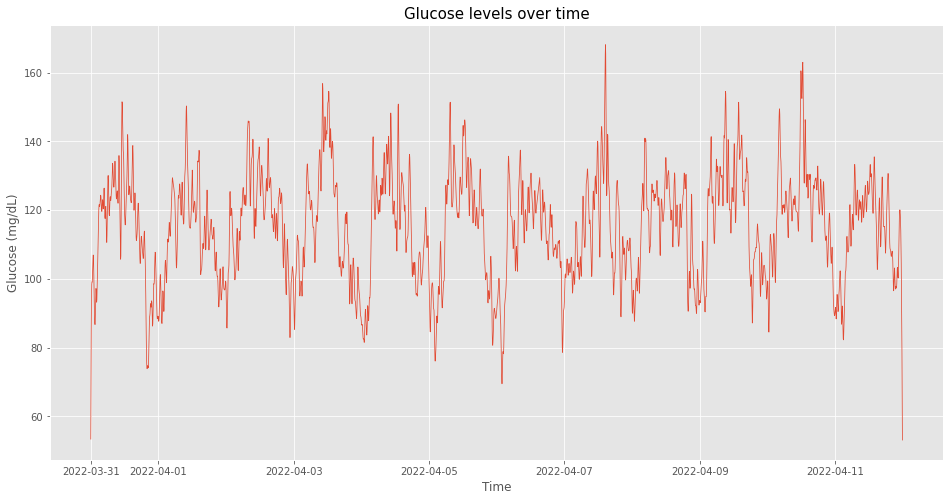

In [ ]:
#@title Plot levels over time for all of the data
# copy so we can restore the rcParams later on
IPython_default = plt.rcParams.copy()

plt.figure(figsize=(16,8))

with plt.style.context('ggplot'):

    plt.plot(df.datetime, df.glucose_level, linewidth=.75)

    #gaussian_filter(glucoses, 10, mode='constant')

    plt.title('Glucose levels over time', fontsize=15)

    plt.xlabel('Time')
    plt.ylabel('Glucose (mg/dL)')
    plt.show()

There's a whole lot of information in the plot above! Let's try to take it step by step and break it down.

## 4.1: Aggregated day-long glucose levels

As a starting point, let's try to reproduce the below graph that you can export from the online Clarity webapp, which shows rough glucose levels over the course of an average day (aggregated over all days measured).

<img src="https://imgur.com/qQwXJIv.png"></img>

*This graph is taken directly from an exported PDF from the online webapp*

First, we'll aggregate across all days and get aggregate glucose level statistics for every 15 minute interval. Then, we'll create a custom plot by leveraging lots of matplotlib functionality, including by poking deeper into the [Matplotlib architecture](https://www.aosabook.org/en/matplotlib.html) into the Artist layer and directly adding rounded rectangles to the plot (the error bars).

Disclaimer: We aren't sure exactly how the error bars are derived, so the reproduced output is different.

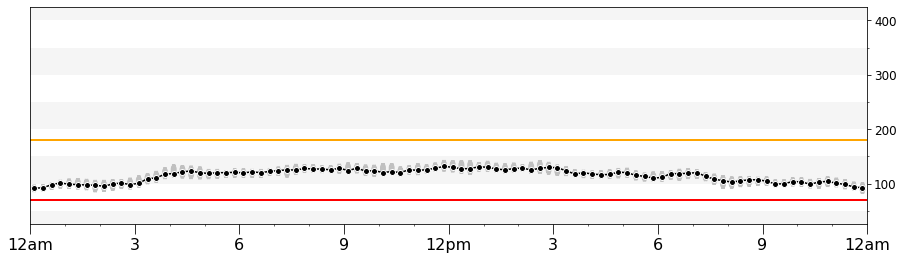

In [ ]:
#@title Aggregated day-long glucose level plot
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.patches as patches

def dt_to_raw_min(dt_obj):
    return int(datetime.strftime(dt_obj, '%H')) * 60 + int(datetime.strftime(dt_obj, '%M'))

raw_mins = np.array([dt_to_raw_min(x) for x in df.datetime])

stats = []

for i in range(0, 24 * 60, 15):
    idxes_of_interest = np.where(np.logical_and(i < raw_mins, raw_mins < i + 15))[0]

    levels = np.array(df.glucose_level.iloc[idxes_of_interest])

    median_level = np.median(levels)

    mean_level = np.mean(levels)

    std_level = np.std(levels)
    stde_level = np.std(levels) / np.sqrt(levels.shape[0])

    stats.append([median_level, mean_level, std_level, stde_level])


# now let's actually plot

fig, ax = plt.subplots(figsize=(15, 4))

# background color in vertical-wise intervals accordingly
for i in range(0, 500, 100):
    plt.axhspan(i, i + 50, facecolor='whitesmoke')#, alpha=0.5)

for i in range(50, 550, 100):
    plt.axhspan(i, i + 50, facecolor='white')

# now do the actual data

# add 7 to make it all centered
plt.plot(range(7, 24 * 60 + 7, 15), [x[0] for x in stats], marker='o', markerfacecolor='black', markeredgecolor='white', color='black')

RECT_WIDTH = 5

for i, (median, mean, std, stde) in enumerate(stats):
    rect_center = 15 * i + 7
    rect_height = stde * 7
    rect = patches.FancyBboxPatch((rect_center - RECT_WIDTH / 2, mean - rect_height / 2),
                                  RECT_WIDTH, rect_height,
                                  boxstyle="round,pad=-0.0040,rounding_size=5.5",
                                  #boxstyle='round',
                                  linewidth=3, fc='silver', ec='silver')

    ax.add_patch(rect)

# now plot horizontal lines
plt.plot([0, 24 * 60], [180, 180], color='orange', linewidth=2)
plt.plot([0, 24 * 60], [70, 70], color='red', linewidth=2)


# now in the rest of the code we'll handle the ticks and borders etc.
plt.ylim(25, 425)

plt.xticks(ticks=np.linspace(0, 24 * 60, 9), labels=['12am', '3', '6', '9', '12pm', '3', '6', '9', '12am'])

# make sure both major and minor x ticks are visible
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    labelsize=16
)

# make major x ticks longer
plt.tick_params(
    axis='x',
    which='major',
    length=10
)

plt.yticks(np.linspace(100, 400, 4).astype(int))

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=True,      # ticks along the bottom edge are off
    labelsize=12
)

# 2 and 1 minor ticks per major tick on x and y-axis, respectively (https://matplotlib.org/3.1.1/gallery/ticks_and_spines/major_minor_demo.html)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(3))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))

# disable vertical and horizontal grid lines
plt.gca().xaxis.grid(False, which='both')
plt.gca().yaxis.grid(False, which='both')

# get the y-axis ticks to appear on the right
plt.gca().yaxis.tick_right()

# show the borders of the box (https://stackoverflow.com/questions/9750699/how-to-display-only-a-left-and-bottom-box-border-in-matplotlib)
for side in ['left', 'right', 'top', 'bottom']:
    plt.gca().spines[side].set_visible(True)
    plt.gca().spines[side].set_color('black')

# https://stackoverflow.com/questions/42045767/how-can-i-change-the-x-axis-in-matplotlib-so-there-is-no-white-space
plt.margins(x=0)

plt.show()

*Above is a plot we created ourselves!*

Looks like we can pretty faithfully recover the same data that's displayed online for us!

## 4.2: Missing data

But how do we know when the user has been using the device? Which days' data did we just extract, and which ones have enough data to analyze?

To figure this out, we'll make a calendar plot. Fortunately, this idea is easy to execute with the use of [`july`](https://github.com/e-hulten/july/), a custom library that allows us to create beautiful calendar plots. Unfortunately, since the device only samples fairly sparsely (roughly every 5 minutes), then it is hard to tell exactly when the device is on or off. As a reasonable proxy of glucose level coverage throughout a particular day, we opt to count the number of hours in that day that the device has logged at least 3 glucose measurements for.

In [ ]:
#@title Specify start and end dates and extract watch usage metrics
start_date = "2022-01-01" #@param {type:"date"}
end_date = "2022-04-30" #@param {type:"date"}

from tqdm import tqdm
import pytz

dates = date_range(start_date, end_date)
data = np.zeros((len(dates), 24))

# populate data array
for idx, date in tqdm(list(enumerate(dates))):
    local_tz = pytz.timezone('America/Los_Angeles')

    day_start = pd.Timestamp(date).replace(tzinfo=local_tz)

    for i in range(24):
        hour_start, hour_end = day_start + pd.Timedelta(hours=i), day_start + pd.Timedelta(hours=i+1)

        # check for number of measurements during this time
        bool_arr = np.logical_and(datetime.fromtimestamp(int(hour_start.timestamp())) < df.datetime,
               df.datetime < datetime.fromtimestamp(int(hour_end.timestamp())))

        num_measurements = len(np.where(bool_arr)[0])

        if num_measurements >= 3:
            data[idx, i] = 1

100%|██████████| 120/120 [00:03<00:00, 38.69it/s]


Now we make the calendar plot! The above cell calculated `data`. `data` is a 2D numpy array with axes (day, hour), where the first axis refers to a particular day and the second axis refers to a particular hour of the day. The value for, say `data[130,8]`, is exactly one if the user wore his watch from 8am to 9am on day 130 (which is 130 days after `start_date` as specified above) and otherwise zero.

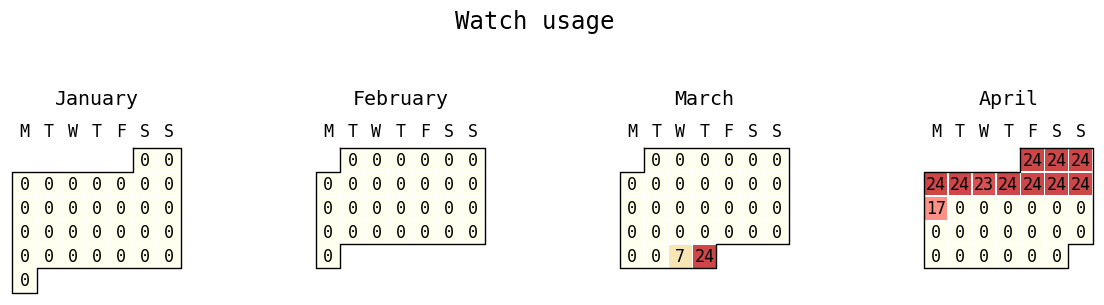

In [ ]:
# sum across hour axis
july.calendar_plot(dates, data.sum(axis=1), value_label=True, weeknum_label=False, title=False)
plt.suptitle('Watch usage', fontsize="x-large", y=1.03)
plt.show()  # suppress output from above line

As we can see, our user was fairly consistent about wearing the device during that time period. She wore the device for every hour of the day for 9 consecutive days.

Now that we've seen high-level data, it's time to dig a bit deeper into day-level statistics.

## 4.3: Glucose levels throughout a particular day

In this section, we reproduce the plot below that you can find when exporting data from the Dexcom Clarity website.

<img src="https://i.imgur.com/w4x37Ua.png" width="1000"/>

*Above is a plot taken directly from the Dexcom Clarity website!*

Just enter any date you would like to plot, and the code below will plot its glucose levels, including missing values.

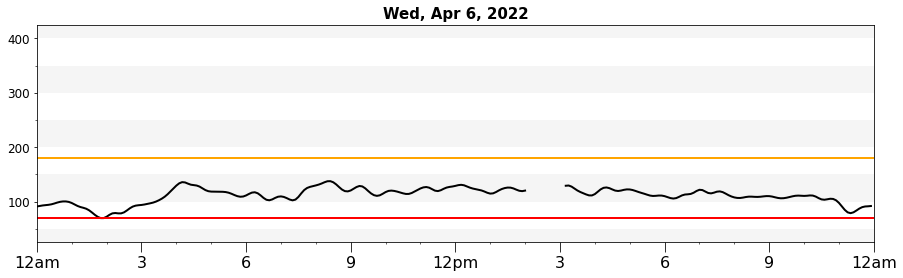

In [ ]:
#@title Visualize single day glucose levels
date_to_visualize = "2022-04-06" #@param {type:"date"}

date_to_visualize_orig = date_to_visualize
date_to_visualize = '-'.join(date_to_visualize.split('-')[1:])

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.patches as patches

import warnings
warnings.filterwarnings("ignore")

# restore rcParams
plt.rcParams.update(IPython_default)

def dt_to_raw_min(dt_obj):
    return int(datetime.strftime(dt_obj, '%H')) * 60 + int(datetime.strftime(dt_obj, '%M'))

raw_mins = np.array([dt_to_raw_min(x) for x in df.datetime])

idxes = np.where(df.datetime.apply(lambda x: datetime.strftime(x, '%m-%d')) == date_to_visualize)[0]
raw_mins = df.datetime.iloc[idxes].apply(lambda x: dt_to_raw_min(x))
glucose_levels = df.glucose_level.iloc[idxes]

# now let's actually plot

fig, ax = plt.subplots(figsize=(15, 4))

# background color in vertical-wise intervals accordingly
for i in range(0, 500, 100):
    plt.axhspan(i, i + 50, facecolor='whitesmoke')

for i in range(50, 550, 100):
    plt.axhspan(i, i + 50, facecolor='white')

# now do the actual data

gaps = list(np.where(np.diff(raw_mins) > 10)[0] + 1)
cur_start = 0
for gap in (gaps + [len(raw_mins)]):
    plt.plot(raw_mins.iloc[cur_start:gap],
             glucose_levels.iloc[cur_start:gap], color='black',
             linewidth=2)
    cur_start = gap

# now plot horizontal lines
plt.plot([0, 24 * 60], [180, 180], color='orange', linewidth=2)
plt.plot([0, 24 * 60], [70, 70], color='red', linewidth=2)


# now in the rest of the code we'll handle the ticks and borders etc.
plt.ylim(25, 425)

plt.xticks(ticks=np.linspace(0, 24 * 60, 9), labels=['12am', '3', '6', '9', '12pm', '3', '6', '9', '12am'])

# make sure both major and minor x ticks are visible
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    labelsize=16
)

# make major x ticks longer
plt.tick_params(
    axis='x',
    which='major',
    length=10
)

plt.yticks(np.linspace(100, 400, 4).astype(int))

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=True,      # ticks along the bottom edge are off
    labelsize=12
)

# 2 and 1 minor ticks per major tick on x and y-axis, respectively (https://matplotlib.org/3.1.1/gallery/ticks_and_spines/major_minor_demo.html)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(3))
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))

# disable vertical and horizontal grid lines
plt.gca().xaxis.grid(False, which='both')
plt.gca().yaxis.grid(False, which='both')

# get the y-axis ticks to appear on the right
plt.gca().yaxis.tick_left()

# show the borders of the box (https://stackoverflow.com/questions/9750699/how-to-display-only-a-left-and-bottom-box-border-in-matplotlib)
for side in ['left', 'right', 'top', 'bottom']:
    plt.gca().spines[side].set_visible(True)
    plt.gca().spines[side].set_color('black')

# https://stackoverflow.com/questions/42045767/how-can-i-change-the-x-axis-in-matplotlib-so-there-is-no-white-space
plt.margins(x=0)

date_to_visualize_fmted = datetime.strftime(datetime.strptime(date_to_visualize_orig, '%Y-%m-%d'), '%a, %b %-d, %Y')

plt.title(f'{date_to_visualize_fmted}', fontsize=15, fontweight='bold')

plt.show()

*Above is a plot we created ourselves!*

# 5. Data Analysis

Data isn't much without some analysis, so we're going to do some in this section.

DISCLAIMER: the analyses below may not be 100% biologically or scientifically grounded; the code is here to assist in your process, if you are interested in asking these kinds of questions.

## 5.1: Blood glucose level vs. time of day (day vs. night) 

Since people (generally) sleep at night and eat during the day, one hypothesis is that glucose values will be different during the day compared to the night. Let's see if this is true. First, we will get the glucose values for each day and separate them into day time and night time values. We define day time as 9AM to 12AM (midnight) and night time as 12AM (midnight) to 9 am here, although these values can be adjusted as dayStart and dayEnd in the code.

In [ ]:
from datetime import time
import scipy.stats as stats

dayStart = time(9, 00, 00)
dayEnd = time(0, 00, 00)

allTimes = pd.to_datetime(df.loc[:,'datetime']).dt.time

if dayStart < dayEnd:
    mask = (allTimes >= dayStart) & (allTimes <= dayEnd)
else:
    mask = (allTimes >= dayStart) | (allTimes <= dayEnd)

df["Time of Day"] = mask
df["Time of Day"] = df["Time of Day"].map({True: 'Day', False: 'Night'})

Let's use [seaborn](https://seaborn.pydata.org/) to generate a scatter plot to take an initial look.

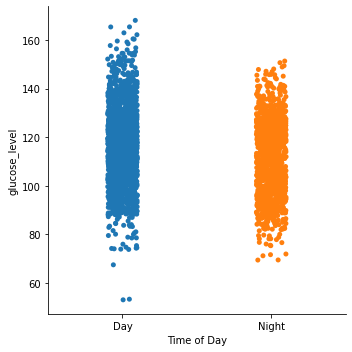

In [ ]:
sns.catplot(x="Time of Day", y="glucose_level", data=df)

Now, since we're compmaring two means, we could use a one-way ANOVA (analysis of variance). For this to be a valid analysis, we have to ensure the data is [independent, normally distributed, and homoscedastic](https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/anova/).

Let's check normality first.

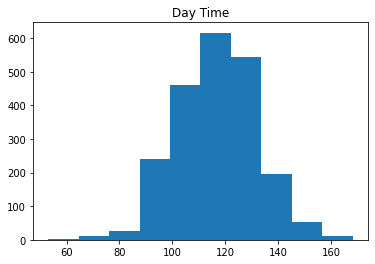

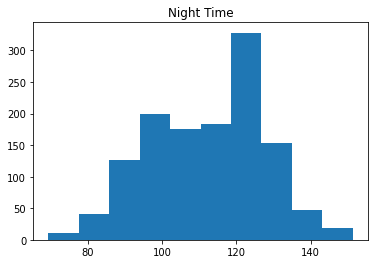

In [ ]:
plt.hist(df.loc[df["Time of Day"] == 'Day']['glucose_level'])
plt.title("Day Time")
plt.show()

plt.hist(df.loc[df["Time of Day"] == 'Night']['glucose_level'])
plt.title("Night Time")
plt.show()

Since the data do not look normally distributed, we can use a [Kruskal-Wallis test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html#scipy.stats.kruskal) instead of an ANOVA.

In [ ]:
stats.kruskal(df.loc[df["Time of Day"] == 'Day']['glucose_level'],df.loc[df["Time of Day"] == 'Night']['glucose_level'])

KruskalResult(statistic=47.03195203081668, pvalue=6.983881212454435e-12)

Thus we can reject the null hypothesis that the population medians do not significantly differ (p<\0.05), and that night time values are different from day time values.

## 5.2: Blood glucose variability vs. time of day (day vs. night)

We also might have an intuition that during the night glucose levels are calmer and vary less in general. Let's see if this is true. We'll check the variability for whether they exhibit significant differences across both groups, as done analogously above. We represent the variability with the standard deviation in the rate of change in the blood glucose levels, as done in [[Clarke & Kovatchev, 2009]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2903980/).

In [ ]:
from datetime import time
import scipy.stats as stats

dayStart = time(9, 00, 00)
dayEnd = time(0, 00, 00)

allTimes = pd.to_datetime(df.loc[:,'datetime']).dt.time

if dayStart < dayEnd:
    mask = (allTimes >= dayStart) & (allTimes <= dayEnd)
else:
    mask = (allTimes >= dayStart) | (allTimes <= dayEnd)

df["Time of Day"] = mask
df["Time of Day"] = df["Time of Day"].map({True: 'Day', False: 'Night'})

rates_of_change = [(df.glucose_level.iloc[i+1] - df.glucose_level.iloc[i]) / ((df.datetime.iloc[i+1] - df.datetime.iloc[i]).seconds / 60) for i in range(df.glucose_level.shape[0] - 1)]
df['Rates of change'] = rates_of_change + [0]  # add extra element to make shapes match

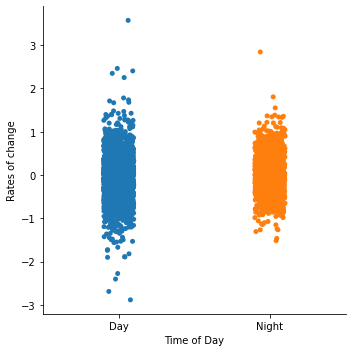

In [ ]:
sns.catplot(x="Time of Day", y="Rates of change", data=df)

From the plot, it looks like the rate of change tends to vary much more during the day! Let's check if this is significant with the F-test, assuming both distributions are normal-distributed.

Note for stats geeks: The F-test works out-of-the-box with variances of the two groups, but since variance is a monotonic + increasing function of standard deviation, it would work out equivalently if we (in theory) went through the trouble of re-deriving the F-distribution and its PDF for standard deviation instead of variance. Therefore, we're still making a statement about standard deviations!

In [ ]:
from scipy.stats import f_oneway
from scipy.stats import f

day_glucoses = np.array(
    df['Rates of change'].iloc[np.where(df['Time of Day'] == 'Day')[0]]
)
night_glucoses = np.array(
    df['Rates of change'].iloc[np.where(df['Time of Day'] == 'Night')[0]]
)

# here we assume that the day variance is greater than the night variance
# if this assumption is violated, the order has to switch

F = np.var(day_glucoses) / np.var(night_glucoses)

df1 = day_glucoses.shape[0] - 1
df2 = night_glucoses.shape[0] - 1

p_value = 1 - f.cdf(F, df1, df2)

print(f'F-value (ratio between variances): {F:.3g}')
print(f'p-value: {p_value:.3g}')

F-value (ratio between variances): 1.24
p-value: 7.01e-06


Looks significant!

Note: statistical test code was adapted from [this StackOverflow post](https://stackoverflow.com/questions/21494141/how-do-i-do-a-f-test-in-python), though the top answer is incorrect (so the version here is fixed).

## 5.3: Anomaly Detection

Finally, we'll be checking for anomalies in the data. This is a crucial step in any sort of analysis, as we want to make sure that all of the data we are analyzing are legit. In favor of interpretability and simplicity, we will use a heuristic that just checks whether a particular datapoint is too different from surrounding points. We do this by fitting a normal to the surrounding datapoints and checking whether the point in question is far enough away from the mean (say, at least five standard deviations away from the mean).

Since our data has no obvious measurement-related anomalies, we manually inject one and verify that our method catches that anomaly but not any others.

In [ ]:
def detect_anomaly(time_arr):
    window_size = 14

    for i, gl in enumerate(time_arr):
        lower_bound = max(i - window_size // 2, 0)
        upper_bound = min(i + window_size // 2, len(time_arr))

        gls = list(time_arr[lower_bound:i]) + list(time_arr[i+1:upper_bound])

        stdev = np.std(gls)

        dist = np.abs(gl - np.mean(gls))
        
        if dist > 5 * stdev:
            print('#' * 40)
            print(f'Anomaly datapoint value: {gl:.3g}')
            print(f'Surrounding datapoints: {time_arr[lower_bound:upper_bound]}')
            print(f'Anomaly is {dist / stdev:.3g} sigma away from the mean of surrounding points')
            print(f'Where sigma = {stdev}')


In [ ]:
glucose_level = np.array(df.glucose_level)
glucose_level[1000] = 250  # manually inject

detect_anomaly(glucose_level)

########################################
Anomaly datapoint value: 250
Surrounding datapoints: [138.6964903  140.85216356 143.06604306 145.51734431 147.15623186
 146.33188987 143.24873083 250.         140.29092961 141.96955006
 143.05601038 142.60336627 142.1804903  143.54608766]
Anomaly is 47 sigma away from the mean of surrounding points
Where sigma = 2.277405484120558
